# Chapter 2. From Model to Production

In [3]:
from fastai.vision.all import *
from fastai.vision.widgets import *

## Gathering Data
Using Bing Images Search

In [4]:
# From https://github.com/fastai/fastbook/blob/master/utils.py
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

def search_images_bing(term, key=os.environ.get('AZURE_SEARCH_KEY'), min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

In [5]:
def download_bing_images(keywords, download_path):
    download_path = Path(download_path)
    if download_path.exists():
        raise Exception('Download folder existed. Please delete and rerun.')
        
    download_path.mkdir()
    
    for k in keywords:
        dest = (download_path/k)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(k)
        download_images(dest, urls=results.attrgot('content_url'))
        
    fns = get_image_files(download_path)
    print(f'Downloaded {len(fns)} images')
    
    # Delete images that can't be opened
    failed = verify_images(fns)
    failed.map(Path.unlink)

In [ ]:
download_bing_images(['puffin', 'toucan', 'penguin'], 'data')

## Data to DataLoaders

In [6]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

In [7]:
dls = db.dataloaders('data')

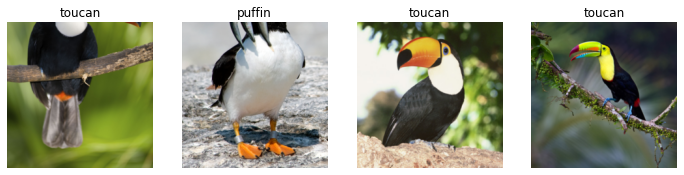

In [8]:
dls.train.show_batch(max_n=4, nrows=1)

### Data augmentation
This is a technique to create different variations of the input data so that they look different but fundamentally are still the input data. For examples, we can rotate, flip, warp, crop the images. In each epoch, a data input is transformed differently to make the training data more robust.

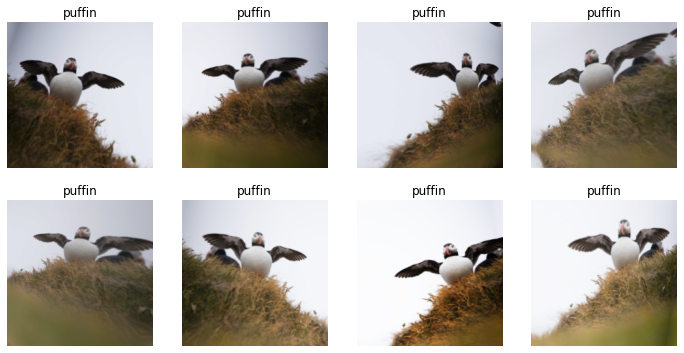

In [9]:
db = db.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))
dls = db.dataloaders('data')
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Modelling

In [10]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.251336,0.167252,0.057471,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.247725,0.076062,0.022989,01:18
1,0.190494,0.124152,0.022989,01:16
2,0.148350,0.135207,0.022989,01:19


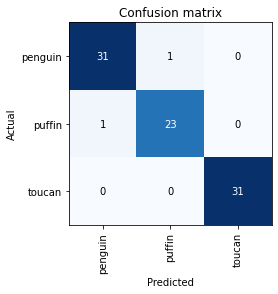

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

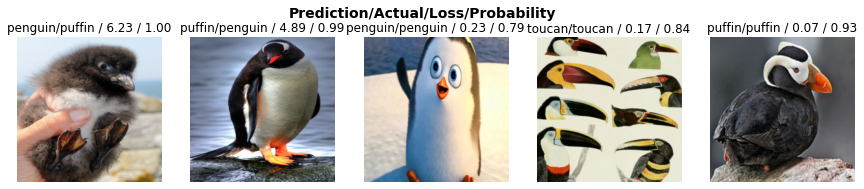

In [12]:
interp.plot_top_losses(5, nrows=1)

In [13]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Apply changes
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Creating an app

In [14]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [23]:
img = PILImage.create(btn_upload.data[-1])

In [38]:
out_pl = widgets.Output()
out_pl.clear_output()
out_pl

Output()

In [34]:
with out_pl: display(img.to_thumb(128,128))

In [30]:
pred,pred_idx,probs = learn.predict(img)

In [39]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: puffin; Probability: 1.0000')

In [36]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
out_pl.clear_output()

In [40]:
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Export the model for later use

In [44]:
learn.export()